In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
%%time
df = pd.read_csv('../data/balanced_data.csv')
df.tail()

Wall time: 578 ms


,short_descriptions,priority
325547,['for' 'office' 'telephone' 'conferencing'],MEDIUM
325548,['missing' 'from' 'open' 'software' 'centre' '...,MEDIUM
325549,['for' 'office' 'change' 'leave' 'maternity' '...,MEDIUM
325550,['local' 'scanner' 'nun' 'nokia' 'detected' 'r...,MEDIUM
325551,['for' 'reset' 'in' 'system' 'initial' 'pwd'],MEDIUM


In [3]:
vectorizer = joblib.load('../models/vectorizer.pkl')
encoder = joblib.load('../models/encoder.pkl')

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    0.0
priority              0.0
dtype: float64

In [5]:
df = df.sample(frac=1)

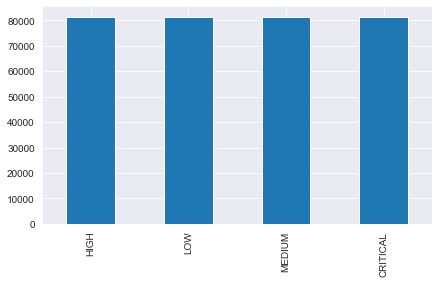

In [6]:
df['priority'].value_counts().plot(kind='bar', figsize=(7, 4))
plt.show()

In [7]:
X = df['short_descriptions'].values
y = df['priority'].values

In [8]:
X

array(["['userid' 're' 'enable' 'account' 'for']", "['user' 'new']",
       "['folder' 'shared' 'it' 'access']", ...,
       "['not' 'accessible' 'tool' 'cronos' 'inaccessible']",
       "['reimage' 'assistance' 'requesting' 'computer' 'windows' 'from' 'oss'\n 'to']",
       "['concierge' 'corner' 'it']"], dtype=object)

In [9]:
y

array(['MEDIUM', 'CRITICAL', 'MEDIUM', ..., 'CRITICAL', 'LOW', 'LOW'],
      dtype=object)

In [10]:
%%time
X = vectorizer.transform(X)

Wall time: 3.89 s


In [11]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 212 ms


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(260441, 29550) (260441,) (65111, 29550) (65111,)


In [14]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Accuracy: {acc} | F1: {f1} | Precision: {precision} | Recall: {recall}')
    
    return acc, f1, precision, recall

In [15]:
%%time

trained_models = dict()

for model in models:
    model_name = model.__class__.__name__
    print(f'Training -> {model_name}')
    
    s = time.time()
    
    predictor = ParallelPostFit(estimator=model)
    predictor.fit(X_train, y_train)
    
    e = time.time()
    
    print(f'Training time: {round(e - s)} seconds')
    
    preds = predictor.predict(X_test)
    
    acc, f1, precision, recall = display_metrics(true=y_test, pred=preds)
    
    trained_models[f1] = predictor   
    
    print('-' * 50)
    
final_model = max(sorted(trained_models.items(), reverse=True))[1]
print('Best model: ', final_model)

Training -> MultinomialNB
Training time: 0 seconds
Accuracy: 78.02 | F1: 77.78 | Precision: 78.48 | Recall: 78.02
--------------------------------------------------
Training -> LogisticRegression
Training time: 21 seconds
Accuracy: 81.98 | F1: 81.71 | Precision: 81.89 | Recall: 81.98
--------------------------------------------------
Training -> RandomForestClassifier
Training time: 1309 seconds
Accuracy: 90.63 | F1: 90.48 | Precision: 90.72 | Recall: 90.63
--------------------------------------------------
Training -> LinearSVC
Training time: 13 seconds
Accuracy: 83.66 | F1: 83.41 | Precision: 83.59 | Recall: 83.66
--------------------------------------------------
Training -> DecisionTreeClassifier
Training time: 122 seconds
Accuracy: 87.31 | F1: 87.08 | Precision: 87.1 | Recall: 87.31
--------------------------------------------------
Best model:  ParallelPostFit(estimator=RandomForestClassifier(n_jobs=-1))
Wall time: 24min 28s


In [30]:
test = np.array([
    'mailbox shared add hr to user'
])

# True Label -> MEDIUM

test = vectorizer.transform(test)

In [31]:
prediction = final_model.predict(test)

In [32]:
encoder.inverse_transform([prediction])

array(['MEDIUM'], dtype=object)

In [33]:
display_metrics(true=y_train, pred=final_model.predict(X_train))

Accuracy: 87.31 | F1: 97.2 | Precision: 97.22 | Recall: 97.21


(87.31, 97.2, 97.22, 97.21)

In [34]:
report = classification_report(y_true=y_test, y_pred=final_model.predict(X_test), output_dict=True)

In [35]:
report_df = pd.DataFrame(report)

In [36]:
new_indices = list(
    encoder.inverse_transform(report_df.columns[:-3].astype('int'))
) + ['accuracy', 'macro avg', 'weighted avg']

In [37]:
report_df.columns = (new_indices)

In [38]:
report_df.T

,precision,recall,f1-score,support
CRITICAL,0.927004,0.969024,0.947548,16303.000000
HIGH,0.987302,0.997790,0.992518,16286.000000
LOW,0.822838,0.901219,0.860247,16167.000000
MEDIUM,0.891175,0.757566,0.818957,16355.000000
accuracy,0.906268,0.906268,0.906268,0.906268
macro avg,0.907080,0.906400,0.904818,65111.000000
weighted avg,0.907222,0.906268,0.904819,65111.000000


In [39]:
report_df.T.to_csv('../data/classification_report.csv')